### Описание проекта

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

### Задача

- Построить модель с высокиими показателями точности,которая будет предсказывать уйдёт клиент из банка в ближайшее время или нет.
- Достигнуть F1 меры 0.59 на тестовой выборке


Признаки
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
-  IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата
- Exited — факт ухода клиента

### 1. Загрузите и подготовьте данные. Поясните порядок действий.

#### 1.1 Загрузка и предобработка данных (пропуски,название столбцов,типы данных)

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.tree import DecisionTreeClassifier #дерево решений 
from sklearn.ensemble import RandomForestClassifier #случайный лес
from sklearn.linear_model import LogisticRegression #логическая регрессия 

from sklearn.model_selection import train_test_split #деление выборки 

from sklearn.preprocessing import StandardScaler #масштабирование количественных признаков
pd.options.mode.chained_assignment = None

from sklearn.metrics import f1_score #подсчет  F1

from sklearn.metrics import roc_curve #график auc_roc
from sklearn.metrics import roc_auc_score #подсчет auc_roc

import matplotlib.pyplot as plt #график

from sklearn.utils import shuffle #перемешивание при семплировании 

from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve

import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning) #убираем ошибку

In [3]:
data = pd.read_csv('/Users/l.stefanenko/Desktop/Yandex/Github/№7 ML_with_teaher_ottok_bank_class/Churn (1).csv')

In [4]:
data.shape

(10000, 14)

In [5]:
display(data.head())

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [6]:
data.rename(columns = {'RowNumber':'row_number',
                      'CustomerId':'customer_id',
                       'CreditScore':'credit_score',
                       'NumOfProducts':'num_of_products',
                       'HasCrCard':'has_cr_card',
                       'IsActiveMember':'is_active_member',
                       'EstimatedSalary':'estimated_salary',
                       'Surname':'surname',
                       'Geography':'geography',
                       'Gender':'gender',
                       'Age':'age',
                       'Tenure':'tenure',
                       'Balance':'balance',
                       'Exited':'exited'
                      },inplace = True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            9091 non-null   float64
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Удалим столбцы, которые неважны для построения моделей

In [7]:
data = data.drop(columns = ['row_number','surname','customer_id'],axis = 1) 

Сделаем предположение, что пропуски в столбце tenure вызваны тем, что пользователь является клиентом банка меньше одного года, поэтому в таблице пропуск. Заменим все пропуски на значение 1 (год) для дальнейшего построения модели. А также изменим типа данных этого столбца на  INT 64 для сокращения затрачиваемой памяти и отбросим нули, поскольку оперируем только целыми числами в данном столбце

In [8]:
data['tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

In [9]:
median = data['tenure'].median()

In [10]:
data['tenure'] = data['tenure'].fillna(median)
data['tenure'] = data['tenure'].astype ('Int64')

In [11]:
data['tenure'].unique()

<IntegerArray>
[2, 1, 8, 7, 4, 6, 3, 10, 5, 9, 0]
Length: 11, dtype: Int64

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  Int64  
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  int64  
 7   has_cr_card       10000 non-null  int64  
 8   is_active_member  10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: Int64(1), float64(2), int64(6), object(2)
memory usage: 869.3+ KB


In [13]:
display(data.head())

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


###  1.2 Подготовка данных для построения моделей

#### 1.2.1 Преобразование качественных признаков техникой OHE

In [14]:
data_ohe = pd.get_dummies(data, columns = ['gender','geography'], drop_first=True)
display(data_ohe)

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,gender_Male,geography_Germany,geography_Spain
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,1,0,0
9996,516,35,10,57369.61,1,1,1,101699.77,0,1,0,0
9997,709,36,7,0.00,1,0,1,42085.58,1,0,0,0
9998,772,42,3,75075.31,2,1,0,92888.52,1,1,1,0


Разобьем датасет на целевой признак target и другие признаки features

In [15]:
target = data_ohe['exited']
features = data_ohe.drop('exited', axis=1)
data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_score       10000 non-null  int64  
 1   age                10000 non-null  int64  
 2   tenure             10000 non-null  Int64  
 3   balance            10000 non-null  float64
 4   num_of_products    10000 non-null  int64  
 5   has_cr_card        10000 non-null  int64  
 6   is_active_member   10000 non-null  int64  
 7   estimated_salary   10000 non-null  float64
 8   exited             10000 non-null  int64  
 9   gender_Male        10000 non-null  uint8  
 10  geography_Germany  10000 non-null  uint8  
 11  geography_Spain    10000 non-null  uint8  
dtypes: Int64(1), float64(2), int64(6), uint8(3)
memory usage: 742.3 KB


Целевой признак категориальный, значит решается задача классификации.

#### Разбили исходные данные на n три выборки в соотношении 20 валидационная :65 обучающая :25 тестовая (%)
- обучающую (train);
- валидационную (valid);
- тестовую (test);

In [16]:
train_valid, test = train_test_split(data_ohe, test_size=0.2, random_state=12345)
train, valid = train_test_split(train_valid, test_size=0.25, random_state=12345)

In [17]:
features_train = train.drop(['exited'],axis = 1) # Переменные для обучающей выборки
target_train = train['exited'] 

In [18]:
features_valid = valid.drop(['exited'],axis = 1) # Переменные для валидационной выборки
target_valid = valid['exited'] 

In [19]:
features_test = test.drop(['exited'],axis = 1) # Переменные для тестовой выборки
target_test = test['exited'] 

In [20]:
print(features_train.shape, target_train.shape)
print(features_valid.shape, target_valid.shape)
print(features_test.shape, target_test.shape)

(6000, 11) (6000,)
(2000, 11) (2000,)
(2000, 11) (2000,)


#### 1.2.2 Масшатбирование количественных признаков методом стандартизации данных

In [21]:
numeric = ['credit_score', 'age', 'balance', 'tenure',
           'estimated_salary','num_of_products']

In [22]:
scaler = StandardScaler()

scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

display(features_train.head())

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,gender_Male,geography_Germany,geography_Spain
492,-0.134048,-0.078068,-0.369113,0.076163,0.816929,0,1,0.331571,0,0,0
6655,-1.010798,0.494555,-0.007415,0.136391,-0.896909,1,1,-0.727858,1,0,0
4287,0.639554,1.353490,-1.454209,0.358435,-0.896909,1,1,-0.477006,1,1,0
42,-0.990168,2.116987,-1.092511,0.651725,-0.896909,1,1,-0.100232,0,0,0
8178,0.567351,0.685430,0.715982,0.813110,0.816929,1,1,0.801922,0,0,0


### 2. Построение модели классификации на сырых данных


#### 2.1 Проверим значение F1 на трех моделях обучения задачи классификации: Случайный лес, дерево решений и логическая регрессия. Выберем из них лучшее значение  F1 

#### Модель случайного леса на сырых данных

In [23]:
best_model = None
best_result = 0
for est in range(1, 30):
    model = RandomForestClassifier(random_state=12345, n_estimators=est)
    model.fit(features_train,target_train)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid,predicted_valid)
    if result > best_result:
        best_model = model
        best_random_tree_result = result

print("F1 Случайного леса:", best_random_tree_result, best_model)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

best_random_tree_aucroc=roc_auc_score(target_valid,probabilities_one_valid)
print('AUC_ROC_raw:',best_random_tree_aucroc)

F1 Случайного леса: 0.5754716981132075 RandomForestClassifier(n_estimators=29, random_state=12345)
AUC_ROC_raw: 0.834302413374894


#### Модель дерева решений на сырых данных

In [24]:
best_model = None
best_result = 0
for depth in range(1, 16):
    model = DecisionTreeClassifier(random_state=12345, max_depth = depth)
    model.fit(features_train,target_train)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid,predicted_valid)
    if result > best_result:
        best_model = model
        best_tree_result = result

print("F1 Дерева решений:", best_tree_result, best_model)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

best_tree_aucroc=roc_auc_score(target_valid,probabilities_one_valid)
print('AUC_ROC_raw:',best_tree_aucroc)

F1 Дерева решений: 0.49933949801849403 DecisionTreeClassifier(max_depth=15, random_state=12345)
AUC_ROC_raw: 0.6938258103792764


#### Модель логической регрессии на сырых данных

In [25]:
best_model = None
best_result = 0
model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=100)#solver='lbfgs',позволяет выбрать алгоритм, который будет строить модель.иперпараметром max_iter задаётся максимальное количество итераций обучения. 
#Значение этого параметра по умолчанию 100, но в некоторых случаях понадобится больше итераций.
model.fit(features_train,target_train)
predicted_valid = model.predict(features_valid)
best_logic_result = f1_score(target_valid,predicted_valid)

print("F1 логической регрессии:", best_logic_result,model)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

best_logic_aucroc=roc_auc_score(target_valid,probabilities_one_valid)
print('AUC_ROC_raw:',best_logic_aucroc)

F1 логической регрессии: 0.30131826741996237 LogisticRegression(random_state=12345)
AUC_ROC_raw: 0.7703391568208877


#### 2.2 Построим график AUC-ROC для сырых данных модели логической регрессии

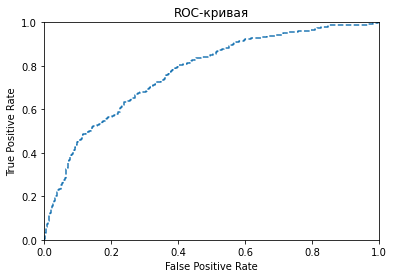

In [26]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

### 3. Построение моделей со сбалансированными весами классов

In [27]:
data['exited'].value_counts()

0    7963
1    2037
Name: exited, dtype: int64

<div class="alert alert-block alert-info">
Видим несбалансированность классов после работы функции value_counts().  Проведем опреции по сбалансированию классов. 

#### Модель случайного леса со сбалансированными классами

In [28]:
best_model = None
best_result = 0
for est in range(1, 30):
    model = RandomForestClassifier(random_state=12345, n_estimators=est,class_weight='balanced')# обучите модель с заданным количеством деревьев
    model.fit(features_train,target_train)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid,predicted_valid)
    if result > best_result:
        best_model = model
        best_random_tree_result_balanced = result

print("F1 Случайного леса:", best_random_tree_result_balanced, best_model)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

best_random_tree_aucroc_balanced=roc_auc_score(target_valid,probabilities_one_valid)
print('AUC_ROC_balanced_случайный лес:',best_random_tree_aucroc_balanced)

F1 Случайного леса: 0.5204582651391163 RandomForestClassifier(class_weight='balanced', n_estimators=29,
                       random_state=12345)
AUC_ROC_balanced_случайный лес: 0.8256816278001459


#### Модель дерева решений со сбалансированными классами

In [29]:
best_model = None
best_result = 0
for depth in range(1, 16):
    model = DecisionTreeClassifier(random_state=12345, max_depth = depth,class_weight='balanced')# обучите модель с заданным количеством деревьев
    model.fit(features_train,target_train)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid,predicted_valid)
    if result > best_result:
        best_model = model
        best_tree_result_balanced = result

print("F1 Дерева решений:", best_tree_result_balanced, best_model)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

best_tree_aucroc_balanced=roc_auc_score(target_valid,probabilities_one_valid)
print('AUC_ROC_balanced_дерево_решений:',best_tree_aucroc_balanced)

F1 Дерева решений: 0.4701670644391408 DecisionTreeClassifier(class_weight='balanced', max_depth=15,
                       random_state=12345)
AUC_ROC_balanced_дерево_решений: 0.6908645264250484


#### Модель логической регрессии со сбалансированными классами

In [30]:
model = LogisticRegression(random_state=12345, solver='liblinear',class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

best_logic_balanced = f1_score(target_valid, predicted_valid)
print("F1 логической регрессии:",best_logic_balanced)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

best_logic_auc_balanced =roc_auc_score(target_valid,probabilities_one_valid)
print('AUC_ROC_balanced_логической регрессии:',best_logic_auc_balanced)

F1 логической регрессии: 0.4741532976827095
AUC_ROC_balanced_логической регрессии: 0.7725660805030526


#### Вывод_сбалансированные классы: наилучший результат
- F1 Случайного леса: 0.5718799368088467 (n_estimators=29)
- AUC_ROC_balanced_случайный лес: 0.8397743511164024

### 4. Работа с классами данных методом Upsampling 

#### 4.1 Разделение выборок на классы 

Разделили обучающую выборку на отрицательные и положительные объекты
- features_zeros — признаки объектов с ответом «0»;
- features_ones — признаки объектов с ответом «1»;
- target_zeros — целевой признак объектов, у которых ответы только «0»;
- target_ones — целевой признак объектов, у которых ответы только «1»

In [31]:
features_zeros= features_train[target_train == 0]
features_ones= features_train[target_train == 1]
target_zeros= target_train[target_train == 0]
target_ones= target_train[target_train == 1]

print(features_zeros.shape)
print(features_ones.shape)
print(target_zeros.shape)
print(target_ones.shape)

(4781, 11)
(1219, 11)
(4781,)
(1219,)


Продублировали объекты положительного класса и объединили их с объектами отрицательного класса.   Видим, что выборки примерно в 4 раза различаются, заначит выберем параметр  repeat =  4

In [32]:
repeat = 4
features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

In [33]:
repeat = 4
def upsample(features, target, repeat):
    features_zeros = features_train[target_train == 0]
    features_ones = features_train[target_train == 1]
    target_zeros = target_train[target_train == 0]
    target_ones = target_train[target_train == 1]
    
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled,target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
print(features_train.shape)
print(features_valid.shape)
print(target_test.shape)

(6000, 11)
(2000, 11)
(2000,)


In [34]:
print(features_upsampled.shape, target_upsampled.shape)

(9657, 11) (9657,)


### 5.Улучшите качество моделей. Обучите разные модели и найдите лучшую. Кратко опишите выводы.

#### 5.1 Построение моделей с использование данных после Upsampling 

#### Модель случайного леса с данными после upsamling

In [35]:
best_model = None
best_result = 0
for est in range(1, 100):
    model = RandomForestClassifier(random_state=12345, n_estimators=est)
    model.fit(features_upsampled,target_upsampled)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid,predicted_valid)
    if result > best_result:
        best_model = model
        best_random_tree_result_up= result

print("F1 Случайного леса на сэмплированных данных:", best_random_tree_result_up, best_model)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

best_random_tree_aucroc_up=roc_auc_score(target_valid,probabilities_one_valid)
print('AUC_ROC_up_на сэмплированных данных:',best_random_tree_aucroc_up)

F1 Случайного леса на сэмплированных данных: 0.5865921787709497 RandomForestClassifier(n_estimators=99, random_state=12345)
AUC_ROC_up_на сэмплированных данных: 0.8418590123649103


#### Модель дерева решений с данными после upsamling

In [36]:
best_model = None
best_result = 0
for depth in range(1, 16):
    model = DecisionTreeClassifier(random_state=12345, max_depth = depth)
    model.fit(features_upsampled,target_upsampled)
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid,predicted_valid)
    if result > best_result:
        best_model = model
        best_tree_result_up = result

print("F1 Дерева решений на сэмплированных данных::", best_tree_result_up, best_model)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

best_tree_aucroc_up=roc_auc_score(target_valid,probabilities_one_valid)
print('AUC_ROC_up_на сэмплированных данных:',best_tree_aucroc_up)

F1 Дерева решений на сэмплированных данных:: 0.47281323877068554 DecisionTreeClassifier(max_depth=15, random_state=12345)
AUC_ROC_up_на сэмплированных данных: 0.6936263250672767


#### Модель логической регрессии с данными после upsamling

In [37]:
model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=100)#solver='lbfgs',позволяет выбрать алгоритм, который будет строить модель.иперпараметром max_iter задаётся максимальное количество итераций обучения. 
#Значение этого параметра по умолчанию 100, но в некоторых случаях понадобится больше итераций.
model.fit(features_upsampled,target_upsampled)
predicted_valid = model.predict(features_valid)

best_logic_up = f1_score(target_valid, predicted_valid)

print("F1 Логической регрессии на сэмплированных данных:", best_logic_up )

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

best_logic_aucroc_up=roc_auc_score(target_valid,probabilities_one_valid)
print('AUC_ROC_up_на сэмплированных данных:',best_logic_aucroc_up)

F1 Логической регрессии на сэмплированных данных: 0.4771126760563381
AUC_ROC_up_на сэмплированных данных: 0.7725676700274511


In [38]:
#model = RandomForestClassifier(random_state=12345, n_estimators=25)
#model.fit(features_upsampled,target_upsampled)
#predicted_valid = model.predict(features_valid)

#probabilities_one_valid = probabilities_valid[:, 1]

#for threshold in np.arange(0, 0.3, 0.02):
    #predicted_valid = probabilities_one_valid > threshold
    #F1 = f1_score(target_valid, predicted_valid)
    #print("Порог = {:.2f} | F1 = {:.3f}".format(
        #threshold, F1))

In [39]:
#model = DecisionTreeClassifier(random_state=12345, max_depth=7)
#model.fit(features_upsampled,target_upsampled)# обучите модель
#predicted_valid = model.predict(features_valid)

#probabilities_one_valid = probabilities_valid[:, 1]

#for threshold in np.arange(0, 0.3, 0.02):
    #predicted_valid = probabilities_one_valid > threshold
    #F1 = f1_score(target_valid, predicted_valid)
    #print("Порог = {:.2f} | F1 = {:.3f}".format(
        #threshold, F1))

In [40]:
#model = LogisticRegression(solver='liblinear',random_state = 12345 )
#model.fit(features_upsampled,target_upsampled)
#predicted_valid = model.predict(features_valid)

#probabilities_one_valid = probabilities_valid[:, 1]

#for threshold in np.arange(0, 0.3, 0.02):
    #predicted_valid = probabilities_one_valid > threshold
    #F1 = f1_score(target_valid, predicted_valid)
    #print("Порог = {:.2f} | F1 = {:.3f}".format(
        #threshold, F1))

#### 5.2 Построим график PR для логической регрессии

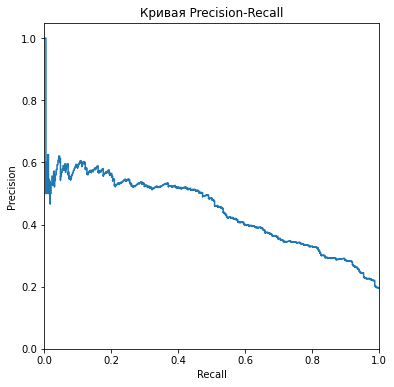

In [41]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled,target_upsampled)

probabilities_valid = model.predict_proba(features_valid)
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show() 

### 6. Выбор лучшей модели и финальное тестирование

#### 6.1 Построение таблицы значений для выбора наилучшей модели и значений

In [42]:
df_train_result = pd.DataFrame(
    columns=['F1_raw', 'AUC_ROC_raw', '|',
             'F1_balanced', 'AUC_ROC_balanced', '|',
             'F1_up', 'AUC_ROC_up', '|'
            ],
    
    index=['случайный_лес',
           'дерево_решений',
           'логистическая_регрессия']
)
df_train_result['|'] =  '|'

#### 6.1.1 Результаты модели для сырых данных

In [43]:
df_train_result.loc['дерево_решений', 'F1_raw'] = best_tree_result
df_train_result.loc['дерево_решений', 'AUC_ROC_raw'] = best_tree_aucroc

In [44]:
df_train_result.loc['случайный_лес', 'F1_raw'] = best_random_tree_result
df_train_result.loc['случайный_лес', 'AUC_ROC_raw'] = best_random_tree_aucroc

In [45]:
df_train_result.loc['логистическая_регрессия', 'F1_raw'] = best_logic_result
df_train_result.loc['логистическая_регрессия', 'AUC_ROC_raw'] = best_logic_aucroc

#### 6.1.2 Результаты модели для сбалансирования данных

In [46]:
df_train_result.loc['дерево_решений', 'F1_balanced'] = best_tree_result_balanced
df_train_result.loc['дерево_решений', 'AUC_ROC_balanced'] = best_tree_aucroc_balanced

In [47]:
df_train_result.loc['случайный_лес', 'F1_balanced'] = best_random_tree_result_balanced
df_train_result.loc['случайный_лес', 'AUC_ROC_balanced'] = best_random_tree_aucroc_balanced

In [48]:
df_train_result.loc['логистическая_регрессия', 'F1_balanced'] = best_logic_balanced
df_train_result.loc['логистическая_регрессия', 'AUC_ROC_balanced'] = best_logic_auc_balanced

#### 6.1.3 Результаты модели для данных после upsamling

In [49]:
df_train_result.loc['дерево_решений', 'F1_up'] = best_tree_result_up
df_train_result.loc['дерево_решений', 'AUC_ROC_up'] = best_tree_aucroc_up

In [50]:
df_train_result.loc['случайный_лес', 'F1_up'] = best_random_tree_result_up
df_train_result.loc['случайный_лес', 'AUC_ROC_up'] = best_random_tree_aucroc_up

In [51]:
df_train_result.loc['логистическая_регрессия', 'F1_up'] = best_logic_up
df_train_result.loc['логистическая_регрессия', 'AUC_ROC_up'] = best_logic_aucroc_up

#### 6.2 Итоговая таблица результатов

In [52]:
display(df_train_result)

,F1_raw,AUC_ROC_raw,|,F1_balanced,AUC_ROC_balanced,|,F1_up,AUC_ROC_up,|
случайный_лес,0.575472,0.834302,|,0.520458,0.825682,|,0.586592,0.841859,|
дерево_решений,0.499339,0.693826,|,0.470167,0.690865,|,0.472813,0.693626,|
логистическая_регрессия,0.301318,0.770339,|,0.474153,0.772566,|,0.477113,0.772568,|


#### Вывод и выбор модели: Наилучшие показатели F1 и AUC-ROC у модели случайного леса с данными после upsamping. Обратимся к расчету  этой модели и возьмем наилучшие показатели n_estimators=99 для предсказаний на тестовой выборке

### 7.  Расчет F1-меры и AUC-ROC на тестовой выборке 

Возьмем для дальнеших расчетов обьедененную выборку Train_valid для  увеличения точности работы модели

In [53]:
features_train = train_valid.drop(['exited'],axis = 1)
target_train = train_valid['exited'] 

In [54]:
model = RandomForestClassifier(random_state=12345, n_estimators=99)
model.fit(features_upsampled,target_upsampled)
predict_test = model.predict(features_test)

result_test = f1_score(target_test,predict_test)
print ("F1 на тестовой выборке:",result_test)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc=roc_auc_score(target_valid,probabilities_one_valid)
print("auc_roc на тестовой выборке:",auc_roc)

F1 на тестовой выборке: 0.5979381443298969
auc_roc на тестовой выборке: 0.8418590123649103


### 8. Общий вывод 
Подготовлена модель случайного леса с показателями (random_state=12345, n_estimators=99) для дальнейшего прогнозирование ухода клиентов из "Бета-банка". 
- Показатели данной модели: 
- F1 : 0.5979381443298969
- auc_roc : 0.8418590123649103